Historical Data Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Fear-Greed Index Columns: ['timestamp', 'value', 'classification', 'date']
Correlation between Fear-Greed Index and Daily PnL: -0.05725161652917338
       sentiment  days  avg_daily_pnl  median_daily_pnl  avg_trades_per_day  \
0   Extreme Fear     6     733.322758         64.569420          387.666667   
1  Extreme Greed    43   26904.504083        541.554710          130.720930   
2           Fear    37   48087.177910       1147.595856          374.837838   
3          Greed    56   10886.295226        423.083319          201.642857   
4        Neutral    16    4666.046374         97.704185          172.250000   

   avg_fg_index  
0     19.500000  
1     78.627907  
2     32.081081  
3     68.678571  
4     50.437500  
   side  trades     total_pnl    

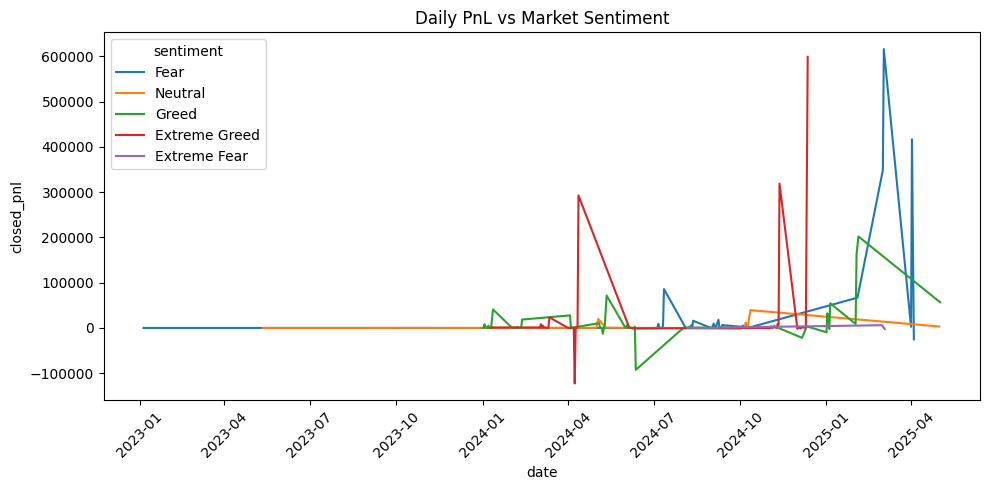

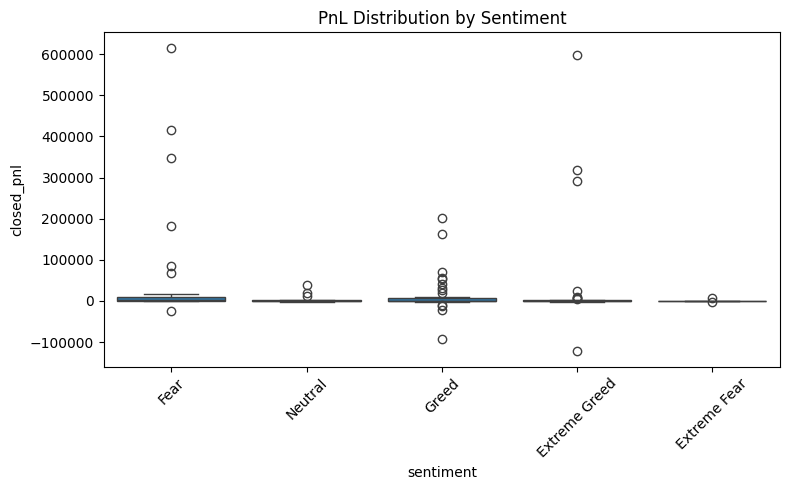

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 2. Load datasets
hist = pd.read_csv("historical_data.csv")
fg = pd.read_csv("fear_greed_index.csv")

# 3. Inspect columns
print("Historical Data Columns:", hist.columns.tolist())
print("Fear-Greed Index Columns:", fg.columns.tolist())

# 4. Rename & clean columns for consistency
hist.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Closed PnL': 'closed_pnl'
}, inplace=True)

# Convert timestamps to datetime
hist['timestamp_ist'] = pd.to_datetime(hist['timestamp_ist'], errors='coerce')
fg['date'] = pd.to_datetime(fg['date'], errors='coerce')
hist['date'] = hist['timestamp_ist'].dt.normalize()
fg['date'] = fg['date'].dt.normalize()

# 5. Aggregate trader data daily
daily_pnl = hist.groupby('date')['closed_pnl'].sum().reset_index()
daily_trades = hist.groupby('date').size().reset_index(name='trade_count')
daily_summary = daily_pnl.merge(daily_trades, on='date')

# 6. Merge with Fear-Greed index
fg.rename(columns={'classification': 'sentiment'}, inplace=True)
merged = pd.merge(daily_summary, fg[['date', 'value', 'sentiment']], on='date', how='inner')

# 7. Correlation check
corr = merged['value'].corr(merged['closed_pnl'])
print("Correlation between Fear-Greed Index and Daily PnL:", corr)

# 8. Summary statistics by sentiment
sentiment_summary = merged.groupby('sentiment').agg(
    days=('date', 'count'),
    avg_daily_pnl=('closed_pnl', 'mean'),
    median_daily_pnl=('closed_pnl', 'median'),
    avg_trades_per_day=('trade_count', 'mean'),
    avg_fg_index=('value', 'mean')
).reset_index()
print(sentiment_summary)

# 9. Side-wise performance
side_summary = hist.groupby('side').agg(
    trades=('side', 'count'),
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    win_rate=('closed_pnl', lambda x: (x > 0).mean()),
    avg_size_usd=('size_usd', 'mean')
).reset_index()
print(side_summary)

# 10. Visualization
plt.figure(figsize=(10,5))
sns.lineplot(data=merged, x='date', y='closed_pnl', hue='sentiment')
plt.title("Daily PnL vs Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='sentiment', y='closed_pnl')
plt.title("PnL Distribution by Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Save outputs
os.makedirs("results", exist_ok=True)
merged.to_csv("results/merged_pnl_sentiment.csv", index=False)
sentiment_summary.to_csv("results/sentiment_summary.csv", index=False)
side_summary.to_csv("results/side_summary.csv", index=False)
